In [1]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
snd = parselmouth.Sound("1.wav")
snd = snd.convert_to_mono()

In [3]:
from IPython.display import Audio
Audio(data=snd.values, rate=snd.sampling_frequency)

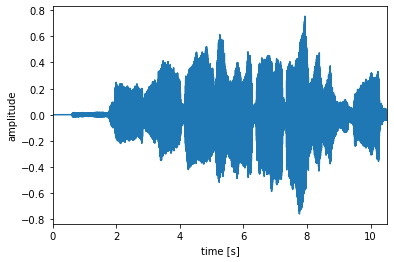

In [4]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

In [5]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2, linewidth=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
    

In [6]:
pitch = snd.to_pitch()

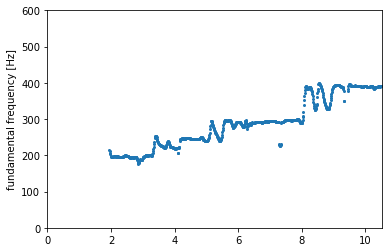

In [7]:
plt.figure()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

In [8]:

def draw_pcd(x,y):
    pitch_values = x.selected_array['frequency']
    #pitch_values[pitch_values==0] = np.nan

    tonic = y

    pitch_ratio = pitch_values/tonic

    #pitch_ratio = np.where(pitch_ratio == 0 , np.nan , pitch_ratio)
    
    #x = -1200 * ( np.log(x) / np.log(2) )

    
    cent_values = pitch_ratio

    i = 0
    while i < cent_values.size:
        if cent_values[i] == 0:
            cent_values[i] = np.nan
        elif cent_values[i]>=1:
            cent_values[i] = 1200 * ( np.log(cent_values[i]) / np.log(2) )
        else:
            cent_values[i] = -1200 * ( np.log(1/cent_values[i]) / np.log(2) )
            
        
        i = i+1
    
    #here we are ensuring that entire thing gets folded into one octave
    
    k = 0
    while k < cent_values.size:
        if cent_values[k] > 1150 :
            cent_values[k] = cent_values[k] - 1200
        elif  cent_values[k] < -50 :
            cent_values[k] = cent_values[k] + 1200
        k = k+1

    l=0
    a=-50
    b=50
    while (l<12):
        print (np.count_nonzero((cent_values >= a) & (cent_values < b))) 
        a = a+100
        b = b+100
        l = l+1
    
    

    bins = [ -50, 50, 150, 250, 350 , 450, 550, 650, 750, 850, 950, 1050, 1150, 1250]
    counts, edges, bars = plt.hist(cent_values , bins=bins , edgecolor='black')
    plt.bar_label(bars)

    #center_bin = [0 , 100 , 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200] 
    #labels = ("S", "R1", "R2","G1", "G2", "M1","M2", "P", "D1","D2", "N1", "N2","S")
    #plt.xticks(center_bin, labels)

    #plt.hist(cent_values , bins=bins , edgecolor='black')
    plt.xlabel('Cent Values', fontsize=10)
    plt.ylabel('No. of Data Points', fontsize=10)
    plt.show()


In [9]:

def feature_fn(x,y):
    pitch_values = x.selected_array['frequency']
    #pitch_values[pitch_values==0] = np.nan

    tonic = y

    pitch_ratio = pitch_values/tonic

    #pitch_ratio = np.where(pitch_ratio == 0 , np.nan , pitch_ratio)
    
    #x = -1200 * ( np.log(x) / np.log(2) )

    
    cent_values = pitch_ratio

    i = 0
    while i < cent_values.size:
        if cent_values[i] == 0:
            cent_values[i] = np.nan
        elif cent_values[i]>=1:
            cent_values[i] = 1200 * ( np.log(cent_values[i]) / np.log(2) )
        else:
            cent_values[i] = -1200 * ( np.log(1/cent_values[i]) / np.log(2) )
            
        
        i = i+1
    
    #here we are ensuring that entire thing gets folded into one octave
    
    k = 0
    while k < cent_values.size:
        if cent_values[k] > 1150 :
            cent_values[k] = cent_values[k] - 1200
        elif  cent_values[k] < -50 :
            cent_values[k] = cent_values[k] + 1200
        k = k+1

    l=0
    a=-50
    b=-45
    arr = np.array([])
    max1 = -9999
    while (l<240):
        sx = (np.count_nonzero((cent_values >= a) & (cent_values < b))) 
        arr = np.append(arr, sx)
        a = a+5
        b = b+5
        l = l+1
        
    
    weights_sum = np.sum(arr)
    #print (arr.shape)
    arr.shape = 12,20
    #print(arr)
    #print (np.amax(arr, axis=1))
    max_index = np.argmax(arr, axis=1)
    #print(max_index)
    
    # here we are extracting index numbers of maximum cents in each row(swara)
    k=0
    while k < max_index.size:
        max_index[k] = max_index[k] + 20*k
        k = k+1
    
    
    #print(max_index)
    
    max_cent = -50 + 5*max_index + 2.5
    #print (max_cent)
    
    #here we are converting each of those cents into frequency 
    max_freq = tonic * np.exp(  (max_cent*np.log(2))/1200  )
    max_freq.shape = 12,1
    #print(max_freq)
    bins = np.linspace(-50, 1150, num=241)

    centered_bins = bins + 2.5
    #print (bins)
    
    centered_bins = np.resize(centered_bins , centered_bins.size - 1)
    centered_bins.shape = 12,20
    #print (centered_bins)
    
    arr_summed = np.sum(arr, axis = 1, keepdims = True)
    
    centered_freq = tonic * np.exp(  (centered_bins*np.log(2))/1200  )
    
    centered_freq_sum = np.sum(centered_freq, axis = 1, keepdims = True)
    
    mean_matrix_temp = np.multiply(centered_freq , arr)
    
    #print (mean_matrix_temp)
    
    mean_matrix_summed = np.sum(mean_matrix_temp , axis = 1, keepdims = True)
    
    #print (mean_matrix_summed)
    
    mean_matrix  = np.divide (mean_matrix_summed ,arr_summed ) #in actual song arr_summed won't be 0. So no worries .... 
     
    #print(max_freq)
    #print(mean_matrix)
    
    # now working for finding standard deviation 
    
    mean_matrix_expand = np.append(mean_matrix,mean_matrix,axis = 1)

    
    i =1
    while i <= 18:
        mean_matrix_expand = np.append(mean_matrix_expand,mean_matrix,axis = 1)
        i = i+1
    
    #print (mean_matrix_expand)
    #print (centered_freq)
    #print (mean_matrix_expand.shape)
    #print (centered_freq.shape)
    
    temp_diff = np.subtract (centered_freq , mean_matrix_expand)
    
    temp_squared  = np.square(temp_diff)
    
    temp_weighted = np.multiply(temp_squared , arr)
    
    #print(temp_squared)
    temp_weighted = np.sum(temp_weighted , axis = 1, keepdims = True)
    
    #print(temp_squared)
    
    stand_dev = np.sqrt (np.divide (temp_weighted , arr_summed))
    
    #print(stand_dev)
    
    prob = np.divide(arr_summed , weights_sum)
    #print (prob)
    
    feature_matrix = max_freq
    feature_matrix = np.append(feature_matrix,mean_matrix,axis =1 )
    feature_matrix = np.append(feature_matrix,stand_dev,axis =1 )
    feature_matrix = np.append(feature_matrix,prob,axis =1 )

    np.set_printoptions(suppress=True, formatter={'float_kind': '{:f}'.format})
    print(feature_matrix)
    #print (centered_freq)
    #print (arr_summed)
    plt.hist(cent_values , bins=bins , edgecolor='black')
    plt.xlabel('Cent Values', fontsize=10)
    plt.ylabel('No. of Data Points', fontsize=10)
    plt.show()


286
10
49
40
109
11
40
220
3
24
20
34


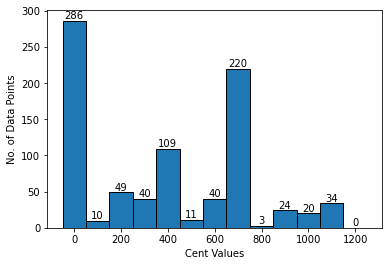

In [10]:
draw_pcd(pitch , 196 )

[[195.717169 195.737549 2.028992 0.338061]
 [202.034777 205.597956 3.622845 0.011820]
 [221.596791 221.857798 2.371942 0.057920]
 [238.877392 233.921089 4.542035 0.047281]
 [245.877034 246.135249 2.899738 0.128842]
 [262.764490 260.594633 3.865670 0.013002]
 [284.896320 279.407524 4.189189 0.047281]
 [293.244420 293.446246 3.155074 0.260047]
 [305.344316 311.043680 6.275725 0.003546]
 [327.259934 331.170328 4.324797 0.028369]
 [341.748970 349.578978 5.543469 0.023641]
 [372.679894 372.407758 5.725536 0.040189]]


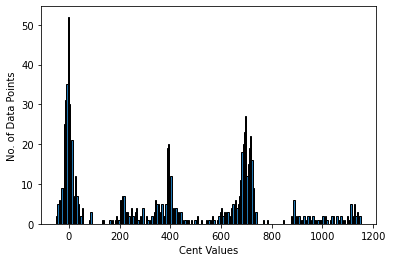

In [11]:
feature_fn(pitch , 196 )